In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from plotting_constants import carrier_colors, nice_carrier_names, policy_colors

In [3]:
z = Path.cwd().parent / 'summaries' / 'total_unit_revenues_flex_zonal.csv'
n = Path.cwd().parent / 'summaries' / 'total_unit_revenues_flex_national.csv'

In [4]:
z = pd.read_csv(z, parse_dates=True, index_col=[0,1])
n = pd.read_csv(n, parse_dates=True, index_col=[0,1])

C:\Users\lukas\AppData\Local\Temp\ipykernel_19772\12831557.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  z = pd.read_csv(z, parse_dates=True, index_col=[0,1])
C:\Users\lukas\AppData\Local\Temp\ipykernel_19772\12831557.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  z = pd.read_csv(z, parse_dates=True, index_col=[0,1])
C:\Users\lukas\AppData\Local\Temp\ipykernel_19772\12831557.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  n = pd.read_csv(n, parse_dates=True, index_col=[0,1])
C:\Users\lukas\AppData\Local\Temp\ipykernel_19772\12831557.py:2: UserWarning: Could n

In [5]:
cfd = pd.read_csv(Path.cwd().parent / 'data' / 'prerun' / 'cfd_strike_prices.csv', index_col=0)

In [6]:
bmus = pd.read_csv(Path.cwd().parent / 'data' / 'prerun' / 'prepared_bmus.csv', index_col=0)

import yaml

with open(Path.cwd().parent / 'data' / 'interconnection_helpers.yaml', 'r') as f:
    inter_bmu = yaml.safe_load(f)['interconnection_mapper']

intercon_lats = []

for i, (key, item) in enumerate(inter_bmu.items()):

    if key == 'Nemo':
        intercon_lats.append(0)
        continue

    lat = bmus.loc[bmus.index.str.startswith(item[0]+'-'), 'lat'].dropna().astype(float).mean()
    intercon_lats.append(lat)

intercon_lats = pd.Series(intercon_lats, index=inter_bmu.keys())

intercon_lats.loc['EastWest'] = 53.23
intercon_lats.loc['Moyle'] = 55.07
intercon_lats.loc['Nemo'] = 51.297

intercon_lats = intercon_lats.to_frame().rename(columns={0: 'lat'})

In [7]:
bmus = pd.read_csv(Path.cwd().parent / 'data' / 'prerun' / 'prepared_bmus.csv', index_col=0)

bmus = bmus.loc[~(bmus['lat'] == 'distributed')]
bmus.loc[:,'lat'] = bmus['lat'].astype(float)

bmu_carriers = pd.concat((
    bmus['carrier'],
    pd.Series('interconnector', intercon_lats.index)
))

bmus = pd.concat([bmus['lat'], intercon_lats])

In [8]:
nice_revenue_names = {
    "wholesale_revenue": "Revenue Change (%) \n Wholesale",
    "roc_revenue": "Revenue Change (%) \n ROC",
    "cfd_revenue": "Revenue Change (%) \n Contracts for Differences",
}

In [9]:
def plot_carrier_share(series, base_ax, coords):
    """
    Plots the carrier share distribution as a horizontal bar on an additional axis.

    Parameters:
      series: Pandas Series with carriers as index and fractional share values.
      base_ax: A matplotlib Axes instance. An additional axis will be added to its figure.
      coords: A tuple or list of [left, bottom, width, height] in figure coordinates defining the new axis extent.
    """
  
      # new_ax = base_ax.figure.add_axes(coords)
    # new_ax = base_ax.add_axes(coords)
    new_ax = base_ax.inset_axes(coords)
    
    cumulative = 0  # keep track of the left boundary for each segment
    for carrier, share in series.items():
        # Convert the fractional share to a percentage width (since 1 -> 100%)
        segment_width = share * 100
        # Get the assigned color for this carrier, defaulting to 'gray' if missing
        color = carrier_colors.get(carrier, 'gray')
        # Draw a horizontal bar for this segment with no edge, for a smooth look
        new_ax.barh(0, width=segment_width, left=cumulative, height=1,
                    color=color, edgecolor='none')
        new_ax.axvline(cumulative, c='k', lw=0.5)

        cumulative += segment_width

    # Adjust the x-axis to run from 0 to 100 with ticks every 20%
    new_ax.set_xlim(0, 100)
    new_ax.set_xticks(list(range(0, 101, 20)))
    new_ax.set_yticks([])  # remove y-axis ticks
    xtick_labels = list(new_ax.get_xticks())
    xtick_labels[-1] = '100%'
    new_ax.set_xticklabels(xtick_labels)

    # new_ax.set_xlabel('(%)')
    # new_ax.set_title('Carrier Share Distribution')

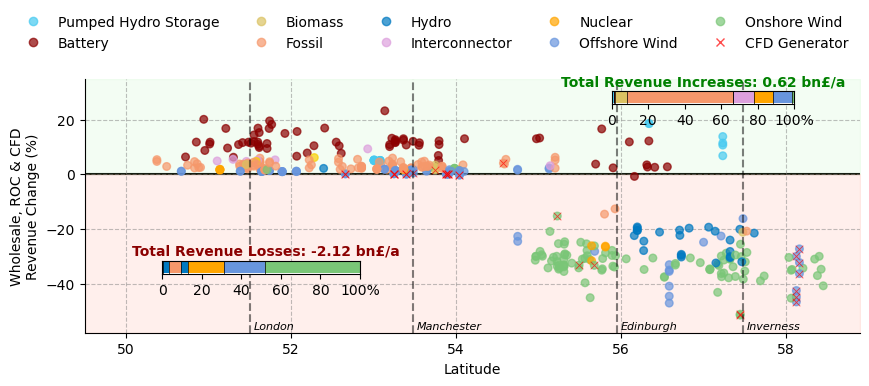

In [10]:
from matplotlib.lines import Line2D


# fig, axs = plt.subplots(3, 1, figsize=(10, 10))
fig, ax = plt.subplots(1, 1, figsize=(10, 3.3))

idx = pd.IndexSlice

used_carriers = set()

# for ax, factor in zip(axs, z.index.get_level_values(1).unique()):
# for ax, factor in zip(axs, list(nice_revenue_names)):
for _ in zip([0]):

    # n_total = n.loc[idx[:,factor], :].replace(np.nan, 0).sum(axis=1)
    # n_total.index = n_total.index.droplevel(1)
    n_total = n.replace(np.nan, 0).groupby(level=0).sum().sum(axis=1)

    # remove units with 0 national revenue
    n_total = n_total[n_total > 0]

    # zonal_total = z.loc[idx[:,factor], :].replace(np.nan, 0).sum(axis=1)
    # zonal_total.index = zonal_total.index.droplevel(1)
    zonal_total = z.replace(np.nan, 0).groupby(level=0).sum().sum(axis=1)

    zonal_total = zonal_total.loc[n_total.index]

    diff = zonal_total - n_total

    hold = diff.to_frame().rename(columns={0: 'diff'})

    hold['carrier'] = bmu_carriers[hold.index]

    phold = hold.loc[hold['diff'] > 0]
    phold = phold.groupby('carrier')['diff'].sum()

    if phold.sum() > 0:
        phold /= phold.sum()

        # if phold.sum() == 1 and len(phold) > 1:
        if len(phold) > 1:
            coords = [0.68, 0.9, 0.235, 0.05]
            plot_carrier_share(phold, ax, coords)

    nhold = hold.loc[hold['diff'] < 0]
    nhold = nhold.groupby('carrier')['diff'].sum().abs()

    nhold /= nhold.sum()

    # if nhold.sum() == 1 and len(nhold) > 1:
    if len(nhold) > 1:
        coords = [0.1, 0.233, 0.255, 0.05]
        plot_carrier_share(nhold, ax, coords)


    nhold /= nhold.sum()
    plus_mask = diff.loc[diff > 0].index

    pos_total_change = np.around(diff.loc[plus_mask].sum() * 1e-9 / 3, decimals=2)
    neg_total_change = np.around(diff.loc[diff < 0].sum() * 1e-9 / 3, decimals=2)
    

    perc_change = (zonal_total / n_total) * 100 - 100

    x = bmus.loc[n_total.index.intersection(bmus.index), 'lat'].astype(float)
    perc_change = perc_change.loc[x.index]

    def get_color(bmu):
        return carrier_colors[bmu_carriers[bmu]]

    new_carriers = [bmu_carriers[bmu] for bmu in x.index]
    used_carriers.update(new_carriers)

    colors = list(map(get_color, x.index))

    # print(x)
    # print(perc_change)

    ax.scatter(
        x,
        perc_change,
        # label=factor,
        color=colors,
        s=30,
        alpha=0.7
        )

    cfd_gens = x.index.intersection(cfd.index)
    ax.scatter(
        x.loc[cfd_gens],
        perc_change.loc[cfd_gens],
        # label=factor,
        color='r',
        s=30,
        alpha=0.7,
        marker='x',
        linewidth=0.6
        )

    ax.grid(True, linestyle='--', color='grey', alpha=0.5)
    ax.set_axisbelow(True)
    # ax.set_ylabel('Revenue Change (%)')
    # ax.set_ylabel(nice_revenue_names[factor])
    ax.set_ylabel('Wholesale, ROC & CFD\nRevenue Change (%)')

    ax.axhline(0., c='k', zorder=0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ylim_upper = 35
    ylim_lower = -58

    ax.set_ylim(ylim_lower, ylim_upper)
    ax.set_xlim(49.5, 58.9)

    ax.fill_between([49.5, 58.9], 0, ylim_upper, color='lightgreen', alpha=0.1, zorder=0)
    ax.fill_between([49.5, 58.9], ylim_lower, 0, color='tomato', alpha=0.1, zorder=0)

    ax.text(
        57,
        34,
        f'Total Revenue Increases: {pos_total_change} bn£/a',
        ha='center',
        va='center',
        fontsize=10,
        color='green',
        fontweight='bold'
    )
    ax.text(
        51.7,
        -28,
        f'Total Revenue Losses: {neg_total_change} bn£/a',
        ha='center',
        va='center',
        fontsize=10,
        color='darkred',
        fontweight='bold'
    )


# Build custom legend handles from the carriers that were used
legend_handles = []
legend_labels = []
for carrier in sorted(used_carriers):

    if carrier in ['cascade', 'solar']:
        continue

    # Get the color for this carrier; default to 'gray' if missing
    color = carrier_colors.get(carrier, 'gray')
    handle = Line2D([0], [0], marker='o', linestyle='None',
                    markerfacecolor=color, markersize=6, markeredgecolor=color,
                    alpha=0.7)

    legend_handles.append(handle)
    legend_labels.append(nice_carrier_names[carrier])


legend_handles.append(
    Line2D(
        [0], [0],
        marker='x',
        color='r',
        markersize=6,
        markeredgecolor='r',
        alpha=0.7,
        linewidth=0.6,
        linestyle='None'
        )
)
legend_labels.append('CFD Generator')

ax.axvline(51.5, c='k', linestyle='--', alpha=0.5)
ax.text(51.55, -55.8, 'London', ha='left', va='center', fontsize=8, color='k', fontstyle='italic')

ax.axvline(53.48, c='k', linestyle='--', alpha=0.5)
ax.text(53.53, -55.8, 'Manchester', ha='left', va='center', fontsize=8, color='k', fontstyle='italic')

ax.axvline(55.95, c='k', linestyle='--', alpha=0.5)
ax.text(56.0, -55.8, 'Edinburgh', ha='left', va='center', fontsize=8, color='k', fontstyle='italic')

ax.axvline(57.48, c='k', linestyle='--', alpha=0.5)
ax.text(57.53, -55.8, 'Inverness', ha='left', va='center', fontsize=8, color='k', fontstyle='italic')

# Place the legend above the first axis (axs[0])
# axs[0].legend(
ax.legend(
    legend_handles,
    legend_labels,
    loc='upper center',
    bbox_to_anchor=(0.45, 1.3),
    ncol=5,
    frameon=False)

ax.set_xlabel('Latitude')

# plt.savefig('annual_unit_revenues_wholesale_ROC_CFD.pdf', bbox_inches='tight')
plt.show()

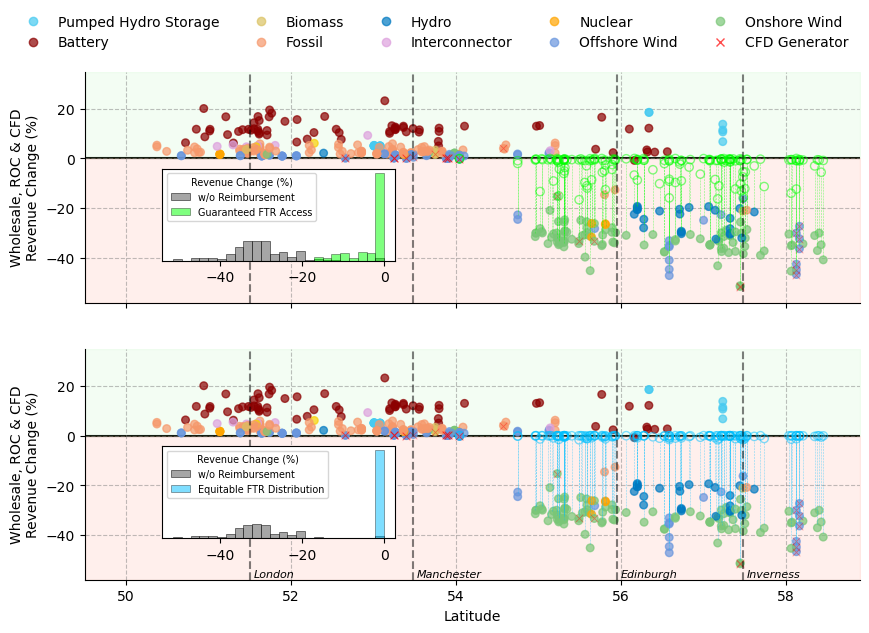

In [40]:
from matplotlib.lines import Line2D

# fig, axs = plt.subplots(3, 1, figsize=(10, 10))
fig, axs = plt.subplots(2, 1, figsize=(10, 6.6))

idx = pd.IndexSlice

used_carriers = set()

n_total = n.replace(np.nan, 0).groupby(level=0).sum().sum(axis=1)
n_total = n_total[n_total > 0]

# zonal_total = z.loc[idx[:,factor], :].replace(np.nan, 0).sum(axis=1)
# zonal_total.index = zonal_total.index.droplevel(1)
zonal_total = z.replace(np.nan, 0).groupby(level=0).sum().sum(axis=1)

zonal_total = zonal_total.loc[n_total.index]

diff = zonal_total - n_total

hold = diff.to_frame().rename(columns={0: 'diff'})

hold['carrier'] = bmu_carriers[hold.index]

phold = hold.loc[hold['diff'] > 0]
phold = phold.groupby('carrier')['diff'].sum()

if phold.sum() > 0:
    phold /= phold.sum()

    # if phold.sum() == 1 and len(phold) > 1:
    if len(phold) > 1:
        coords = [0.68, 0.9, 0.235, 0.05]
        plot_carrier_share(phold, ax, coords)

nhold = hold.loc[hold['diff'] < 0]
nhold = nhold.groupby('carrier')['diff'].sum().abs()

nhold /= nhold.sum()

# if nhold.sum() == 1 and len(nhold) > 1:
if len(nhold) > 1:
    coords = [0.1, 0.233, 0.255, 0.05]
    plot_carrier_share(nhold, ax, coords)


nhold /= nhold.sum()
plus_mask = diff.loc[diff > 0].index

pos_total_change = np.around(diff.loc[plus_mask].sum() * 1e-9 / 3, decimals=2)
neg_total_change = np.around(diff.loc[diff < 0].sum() * 1e-9 / 3, decimals=2)


perc_change = (zonal_total / n_total) * 100 - 100

x = bmus.loc[n_total.index.intersection(bmus.index), 'lat'].astype(float)
perc_change = perc_change.loc[x.index]

def get_color(bmu):
    return carrier_colors[bmu_carriers[bmu]]

new_carriers = [bmu_carriers[bmu] for bmu in x.index]
used_carriers.update(new_carriers)

colors = list(map(get_color, x.index))

    # print(x)
    # print(perc_change)

ss = perc_change.loc[perc_change < 0]

mask = np.random.choice([True, False], size=len(ss), p=[0.6, 0.4])

ss2 = pd.Series(index=ss.index, dtype=float)
ss2[mask] = np.random.uniform(-1, 0, size=mask.sum())

for idx in ss.index[~mask]:
    ss2[idx] = np.random.uniform(0, ss[idx]/2)

ss3 = ss2.mul(0.1)

perc_change_2 = perc_change.copy()
perc_change_2.loc[ss.index] = ss2

perc_change_3 = perc_change.copy()
perc_change_3.loc[ss.index] = ss3

for ax, policy_values, c, name in zip(
    axs,
    [perc_change_2, perc_change_3],
    [policy_colors['zonal'], policy_colors['zonal_with_policy']],
    ['Guaranteed FTR Access', 'Equitable FTR Distribution']
    ):
    
    # Create inset axis for histogram
    inset_ax = ax.inset_axes([0.1, 0.18, 0.3, 0.4])
    
    # Get negative values for histograms
    neg_perc_change = perc_change[perc_change < 0]
    neg_policy_values = policy_values[policy_values < 0]
    
    # Plot histograms of negative revenue changes
    bins = np.linspace(min(neg_perc_change.min(), neg_policy_values.min()), 0, 25)
    inset_ax.hist(neg_perc_change, bins=bins, alpha=0.7, color='gray', 
                 label='w/o Reimbursement', edgecolor='black', linewidth=0.5)
    inset_ax.hist(neg_policy_values, bins=bins, alpha=0.5, color=c, 
                 label=name, edgecolor='black', linewidth=0.5)
    
    inset_ax.set_yticks([])
    inset_ax.legend(loc='upper left', fontsize='x-small', title='Revenue Change (%)', title_fontsize='x-small')
    
    ax.scatter(
        x,
        perc_change,
        # label=factor,
        color=colors,
        s=30,
        alpha=0.7
        )
    
    offset = 1.6
    for (x0, lower, upper) in zip(x, perc_change, policy_values):
        if lower > 0:
            continue
        ax.plot([x0, x0], [lower+offset, upper-offset], c=c, alpha=0.5, linestyle='--', linewidth=0.4)
        ax.scatter([x0], [upper], alpha=0.5, marker='o', facecolors='none', color=c)


    cfd_gens = x.index.intersection(cfd.index)
    ax.scatter(
        x.loc[cfd_gens],
        perc_change.loc[cfd_gens],
        # label=factor,
        color='r',
        s=30,
        alpha=0.4,
        marker='x',
        linewidth=0.6
        )

    ax.grid(True, linestyle='--', color='grey', alpha=0.5)
    ax.set_axisbelow(True)
    # ax.set_ylabel('Revenue Change (%)')
    # ax.set_ylabel(nice_revenue_names[factor])
    ax.set_ylabel('Wholesale, ROC & CFD\nRevenue Change (%)')

    ax.axhline(0., c='k', zorder=0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ylim_upper = 35
    ylim_lower = -58

    ax.set_ylim(ylim_lower, ylim_upper)
    ax.set_xlim(49.5, 58.9)

    ax.fill_between([49.5, 58.9], 0, ylim_upper, color='lightgreen', alpha=0.1, zorder=0)
    ax.fill_between([49.5, 58.9], ylim_lower, 0, color='tomato', alpha=0.1, zorder=0)

    # Build custom legend handles from the carriers that were used
    legend_handles = []
    legend_labels = []
    for carrier in sorted(used_carriers):

        if carrier in ['cascade', 'solar']:
            continue

        # Get the color for this carrier; default to 'gray' if missing
        color = carrier_colors.get(carrier, 'gray')
        handle = Line2D([0], [0], marker='o', linestyle='None',
                        markerfacecolor=color, markersize=6, markeredgecolor=color,
                        alpha=0.7)

        legend_handles.append(handle)
        legend_labels.append(nice_carrier_names[carrier])


    legend_handles.append(
        Line2D(
            [0], [0],
            marker='x',
            color='r',
            markersize=6,
            markeredgecolor='r',
            alpha=0.7,
            linewidth=0.6,
            linestyle='None'
            )
    )
    legend_labels.append('CFD Generator')

    ax.axvline(51.5, c='k', linestyle='--', alpha=0.5)
    ax.axvline(53.48, c='k', linestyle='--', alpha=0.5)
    ax.axvline(55.95, c='k', linestyle='--', alpha=0.5)
    ax.axvline(57.48, c='k', linestyle='--', alpha=0.5)


axs[1].text(51.55, -55.8, 'London', ha='left', va='center', fontsize=8, color='k', fontstyle='italic')
axs[1].text(53.53, -55.8, 'Manchester', ha='left', va='center', fontsize=8, color='k', fontstyle='italic')
axs[1].text(56.0, -55.8, 'Edinburgh', ha='left', va='center', fontsize=8, color='k', fontstyle='italic')
axs[1].text(57.53, -55.8, 'Inverness', ha='left', va='center', fontsize=8, color='k', fontstyle='italic')

# Place the legend above the first axis (axs[0])
# axs[0].legend(
axs[0].legend(
    legend_handles,
    legend_labels,
    loc='upper center',
    bbox_to_anchor=(0.45, 1.3),
    ncol=5,
    frameon=False)

axs[0].set_xticklabels('')

axs[1].set_xlabel('Latitude')

plt.savefig('annual_policy_revenue_changes.pdf', bbox_inches='tight')
plt.show()

In [12]:
does the cfd revenue consider that wholesale prices must be positive for topup !

SyntaxError: invalid syntax (646183353.py, line 1)

In [9]:
n_total.index[100:150]

Index([], dtype='object', name='asset')

In [49]:
# windfall tax
import matplotlib

help(matplotlib.figure.Figure.add_axes)

Help on function add_axes in module matplotlib.figure:

add_axes(self, *args, **kwargs)
    Add an `~.axes.Axes` to the figure.

    Call signatures::

        add_axes(rect, projection=None, polar=False, **kwargs)
        add_axes(ax)

    Parameters
    ----------
    rect : tuple (left, bottom, width, height)
        The dimensions (left, bottom, width, height) of the new
        `~.axes.Axes`. All quantities are in fractions of figure width and
        height.

    projection : {None, 'aitoff', 'hammer', 'lambert', 'mollweide', 'polar', 'rectilinear', str}, optional
        The projection type of the `~.axes.Axes`. *str* is the name of
        a custom projection, see `~matplotlib.projections`. The default
        None results in a 'rectilinear' projection.

    polar : bool, default: False
        If True, equivalent to projection='polar'.

    axes_class : subclass type of `~.axes.Axes`, optional
        The `.axes.Axes` subclass that is instantiated.  This parameter
        is i